In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from scipy.integrate import simps
from sklearn.metrics import f1_score

import timeit
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training Setup

In [7]:
from torchvision import datasets, models, transforms
import os
from ScaleSquareTransform import ScaleSquare
cwd = os.getcwd()

data_transforms = {
    'train': transforms.Compose([
        ScaleSquare(224),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        ScaleSquare(224),
        transforms.ToTensor()
    ]),
}

data_dir = os.path.join(cwd,"dataset")
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=25,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}

dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes
print_every = 100


In [3]:
# Verify that CUDA is properly configured and you have a GPU available
gpu_dtype = torch.cuda.FloatTensor
torch.cuda.is_available()

True

In [38]:
def train(model, loss_fn, loader, optimizer, num_epochs = 1, print_every=100):
    loss_history = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            loss_data = loss.data[0]
            loss_history.append(loss_data)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss_data))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return loss_history

def check_accuracy(model, loader):    
    softmax_fn = nn.Softmax()
    prob_scores_corr = []
    prob_scores_incorr = []
    all_preds = []
    all_y = []
    num_correct = 0
    num_samples = 0
    incorrect_x = {0:[],1:[]}
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)
        y_cuda = y.type(torch.cuda.LongTensor)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)

        all_preds.append(preds)
        all_y.append(y)
        prob_score = softmax_fn(scores).data.cpu()
        for i,x_i in enumerate(x):
            if (preds[i]!=y[i])[0] == 1:
                incorrect_x[preds[i][0]].append(x_i.unsqueeze(0))
            prob_scores_corr.append(prob_score[i][y[i]])
            prob_scores_incorr.append(prob_score[i][1-y[i]])

    y_true = torch.cat(all_y,0)
    y_pred = torch.cat(all_preds,0)
    f1score = f1_score(y_true.numpy(), y_pred.numpy(), average='micro')

    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc, incorrect_x, prob_scores_corr, prob_scores_incorr, f1score

In [15]:
def get_incorr_loader(model, incorrects):
    all_inc_val = []
    all_inc_val.extend(incorrects[0])
    all_inc_val.extend(incorrects[1])
    inc_dataset_val = torch.cat(all_inc_val, 0)
    targets_val = torch.cat([torch.LongTensor(len(incorrects[0])).fill_(1), torch.LongTensor(len(incorrects[1])).fill_(0)], 0)
    incorr_val = torch.utils.data.TensorDataset(inc_dataset_val, targets_val)
    incorr_loader_val = torch.utils.data.DataLoader(incorr_val, batch_size=4, shuffle=True)
    return incorr_loader_val

In [10]:
loss_fn = nn.CrossEntropyLoss()

## Train all of the models

### Resnet 34

In [ ]:
model_18 = models.resnet18(pretrained=True)
model_18.fc = nn.Linear(model_18.fc.in_features, 2)
model_18.cuda()
model_18.load_state_dict(torch.load(os.path.join(cwd,"model_params_extra_incor2.pth")))

In [21]:
model_34 = models.resnet34(pretrained=True)
model_34.fc = nn.Linear(model_34.fc.in_features, 2)
model_34.cuda()

optimizer_34 = optim.Adam(model_34.parameters(), lr=10**-3.89, betas=(0.9, 0.99), weight_decay=0.009)

loss_history_34 = train(model_34, loss_fn, dset_loaders["train"], optimizer_34, num_epochs=5)
acc, incorrects_34, prob_scores_corr_34, prob_scores_incorr_34, f1score_34 = check_accuracy(model_34, dset_loaders["val"])
print("False negatives:",len(incorrects_34[0]))
print("False positives:",len(incorrects_34[1]))
print("F1 score",f1score_34)

Starting epoch 1 / 5
Starting epoch 2 / 5
Starting epoch 3 / 5
Starting epoch 4 / 5
Starting epoch 5 / 5
Got 436 / 439 correct (99.32)
False negatives: 2
False positives: 1


In [22]:
#torch.save(model_34.state_dict(), os.path.join(cwd,"model_params_resnet_34.pth"))

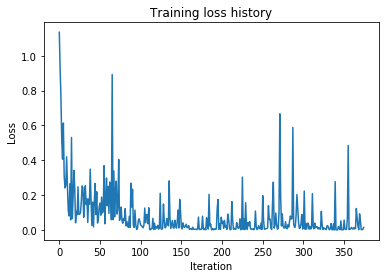

In [23]:
# Plot the training losses
plt.plot(loss_history_34)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

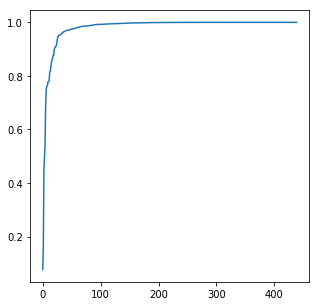

In [27]:
sorted_prob_scores_corr_34 = sorted(prob_scores_corr_34)
plt.plot(sorted_prob_scores_corr_34, '-')
plt.gcf().set_size_inches(5, 5)
plt.show()

In [28]:
area = simps(sorted_prob_scores_corr_34, dx=1)
print("area =", area)

area = 429.815651653


### Resnet 50

In [45]:
model_50 = models.resnet50(pretrained=True)
model_50.fc = nn.Linear(model_50.fc.in_features, 2)
model_50.cuda()

optimizer_50 = optim.Adam(model_50.parameters(), lr=10**-3.89, betas=(0.9, 0.99), weight_decay=0.009)

loss_history_50 = train(model_50, loss_fn, dset_loaders["train"], optimizer_50, num_epochs=5)
acc, incorrects_50, prob_scores_corr_50, _, f1score_50 = check_accuracy(model_50, dset_loaders["val"])
print("False negatives:",len(incorrects_50[0]))
print("False positives:",len(incorrects_50[1]))
print("F1 score",f1score_50)

Starting epoch 1 / 5
Starting epoch 2 / 5
Starting epoch 3 / 5
Starting epoch 4 / 5
Starting epoch 5 / 5
Got 434 / 439 correct (98.86)
False negatives: 3
False positives: 2
F1 score 0.98861047836


In [46]:
#torch.save(model_50.state_dict(), os.path.join(cwd,"model_params_resnet_50.pth"))

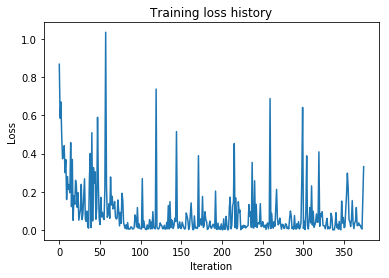

In [47]:
# Plot the training losses
plt.plot(loss_history_50)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

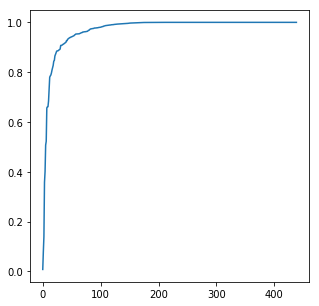

area = 425.340020858


In [48]:
sorted_prob_scores_corr_50 = sorted(prob_scores_corr_50)
plt.plot(sorted_prob_scores_corr_50, '-')
plt.gcf().set_size_inches(5, 5)
plt.show()

area = simps(sorted_prob_scores_corr_50, dx=1)
print("area =", area)

### Resnet 101

In [ ]:
model_101 = models.resnet101(pretrained=True)
model_101.fc = nn.Linear(model_101.fc.in_features, 2)
model_101.cuda()

optimizer_101 = optim.Adam(model_101.parameters(), lr=10**-4, betas=(0.9, 0.99), weight_decay=0.009)

loss_history_101 = train(model_101, loss_fn, dset_loaders["train"], optimizer_101, num_epochs=5)
acc, incorrects_101, prob_scores_corr_101, _, f1score_101 = check_accuracy(model_101, dset_loaders["val"])
print("False negatives:",len(incorrects_101[0]))
print("False positives:",len(incorrects_101[1]))
print("F1 score",f1score_101)

Starting epoch 1 / 5
Starting epoch 2 / 5


In [ ]:
torch.save(model_101.state_dict(), os.path.join(cwd,"model_params_resnet_101.pth"))

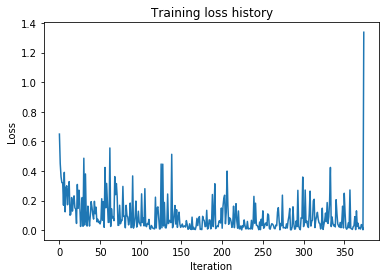

In [51]:
# Plot the training losses
plt.plot(loss_history_101)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [ ]:
sorted_prob_scores_corr_101 = sorted(prob_scores_corr_101)
plt.plot(sorted_prob_scores_corr_101, '-')
plt.gcf().set_size_inches(5, 5)
plt.show()

area = simps(sorted_prob_scores_corr_101, dx=1)
print("area =", area)

### Resnet 152

In [ ]:
model_152 = models.resnet152(pretrained=True)
model_152.fc = nn.Linear(model_152.fc.in_features, 2)
model_152.cuda()

optimizer_152 = optim.Adam(model_152.parameters(), lr=10**-3.89, betas=(0.9, 0.99), weight_decay=0.009)

loss_history_152 = train(model_152, loss_fn, dset_loaders["train"], optimizer_152, num_epochs=5)
acc, incorrects_152, prob_scores_corr_152, _, f1score_152 = check_accuracy(model_152, dset_loaders["val"])
print("False negatives:",len(incorrects_152[0]))
print("False positives:",len(incorrects_152[1]))
print("F1 score",f1score_152)

In [ ]:
torch.save(model_152.state_dict(), os.path.join(cwd,"model_params_resnet_152.pth"))

In [ ]:
# Plot the training losses
plt.plot(loss_history_152)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [ ]:
sorted_prob_scores_corr_152 = sorted(prob_scores_corr_152)
plt.plot(sorted_prob_scores_corr_152, '-')
plt.gcf().set_size_inches(5, 5)
plt.show()

area = simps(sorted_prob_scores_corr_152, dx=1)
print("area =", area)

## Ensemble

In [ ]:
def check_accuracy_ensemble(models, loader, thresh=0.5, scheme='ave'):    
    softmax_fn = nn.Softmax()
    prob_scores_corr = []
    prob_scores_incorr = []
    all_preds = []
    all_y = []
    num_models = len(models)
    num_correct = 0
    num_samples = 0
    incorrect_x = {0:[],1:[]}
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)
        y_cuda = y.type(torch.cuda.LongTensor)

        ave_prob_scores = []
        for model in models:
            scores = model(x_var)
            prob_score = softmax_fn(scores).data.cpu()
            ave_prob_scores.append(prob_score)

        preds = None
        if scheme == 'ave':
            ave_prob_score = torch.stack(ave_prob_scores).sum(0)/num_models
            preds = ave_prob_score.gt(thresh)
        else if scheme == 'max':
            preds = torch.stack(ave_prob_scores).max(0)
        else:
            raise NotImplementedError
        
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)

        all_preds.append(preds)
        all_y.append(y)
        
        for i,x_i in enumerate(x):
            if (preds[i]!=y[i])[0] == 1:
                incorrect_x[preds[i][0]].append(x_i.unsqueeze(0))
            prob_scores_corr.append(prob_score[i][y[i]])
            prob_scores_incorr.append(prob_score[i][1-y[i]])

    y_true = torch.cat(all_y,0)
    y_pred = torch.cat(all_preds,0)
    f1score = f1_score(y_true.numpy(), y_pred.numpy(), average='micro')

    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc, incorrect_x, prob_scores_corr, prob_scores_incorr, f1score

Check validation set against all models

In [ ]:
models = [model_18, model_34, model_50, model_101, model_152]
acc, incorrects, prob_scores_corr, _, f1score = check_accuracy_ensemble(models, dset_loaders["val"])
print("False negatives:",len(incorrects[0]))
print("False positives:",len(incorrects[1]))
print("F1 score",f1score)

In [ ]:
sorted_prob_scores_corr = sorted(prob_scores_corr)
plt.plot(sorted_prob_scores_corr, '-')
plt.gcf().set_size_inches(5, 5)
plt.show()

area = simps(sorted_prob_scores_corr, dx=1)
print("area =", area)

In [ ]:
from TestModelEnsemble import TestModelEnsemble

TestModelEnsemble(models).submit()